<div class="alert alert-block alert-success">
<b>NOTEBOOK 1 - Data Loading
</div>

In [34]:
problem_spec = {
    "decision": "target_student_support",   # Action: who gets extra mentoring/aid
    "unit": "student",                      # Prediction unit
    "event": "dropout_enrolled_graduate",   # Target variable
    "horizon_semesters": "full_program",    # Predict until end of degree
    "prediction_time": "end_of_semester_2", # Only use features available at this point
    "feature_list": [
        # Demographics (static at enrollment)
        "age_at_enrollment",
        "gender",
        "marital_status",
        "parents_education",
        "parents_occupation",
        "scholarship_holder",
        "tuition_fees_up_to_date",
        "admission_grade",
        # Early performance (available by semester 2)
        "curricular_units_1st_sem",
        "curricular_units_2nd_sem",
        "average_grade_1st_sem",
        "average_grade_2nd_sem",
        # Contextual
        "unemployment_rate",
        "gdp_at_enrollment"
    ]
}

---
# 1 - IMPORTS

### 1.1 - LIBRARIES

I have started off importing the necessary modules and libreries for this initial notebook. The module "utils" stores general functions I am going to use throughout this project. 
Make sure to check `README.md` and `requirements.txt` before running any notebooks. 

In [35]:
# IMPORTS

# Standard libraries
import re
import sys
import importlib
from pathlib import Path
from typing import Union

# Third-party: core scientific
import difflib
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Add "../src/utilities" to sys.path for custom utilities
sys.path.append("../src/utilities")  # Ensure src/ is in path

# Import utils
try:
    import utils
    importlib.reload(utils)   # Ensures latest version is loaded
except ImportError as e:
    raise ImportError(f"Could not import utils module: {e}")

---
# 2 - DATASET LOAD

### 2.1 - LOADING

I moved on to loading the dataset by means of the function load.dataset().

In [36]:
# Load dataset
df = utils.load_dataset('../data/raw/student_dropout_success.csv')

Data loaded correctly!


---
# 3 - EXPLORATION

To start off, I have explored the **first rows** of the dataset, gotten the **main info** and **described the features**, just to have a rough overview of what I would have had to deal with later on.

### 3.1 - QUICK EXPLORATION

In [37]:
# Look at the first few rows
df.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Then I have extracted some info regarding each feature (non-nuull counts, types etc...).

In [38]:
# Get basic info about each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [39]:
# Basic statistics for numerical columns
df.describe()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [40]:
# A quick peek at the data shape
print("Dataset Shape:", df.shape)  # (rows, columns)
print("Number of features:", len(df.columns))
print("Number of samples:", len(df))

Dataset Shape: (4424, 37)
Number of features: 37
Number of samples: 4424


I quickly explored the main features of the dataset (`head`, `info`, `shape`). The initial check shows that:

- there are **37 features** in total  
- **4424 entries** (students)  
- Several **numerical features** (grades, age, macroeconomic indicators, curricular units, etc.)  
- Several **categorical features** (marital status, gender, course, nationality, parental occupation/qualification, etc.)  
- No explicit identifier column (all features appear to be student descriptors or outcomes)  
- The **target variable** is `Target` (categorical: `Dropout`, `Enrolled`, `Graduate`)  

The table below summarizes the dataset features, their type and a short description.  
(*This is an initial draft – descriptions/assumptions will be refined later on.*)

| Feature Name                                  | Type                                | Description                                                                 |
|-----------------------------------------------|-------------------------------------|-----------------------------------------------------------------------------|
| `Marital status`                              | Categorical (multi-class, int64)    | Marital status of the student (coded numerically).                          |
| `Application mode`                            | Categorical (multi-class, int64)    | Mode of application (admission channel, encoded).                           |
| `Application order`                           | Numerical (int64, discrete)         | Order of the chosen course preference.                                      |
| `Course`                                      | Categorical (multi-class, int64)    | Course/program enrolled (encoded IDs).                                      |
| `Daytime/evening attendance`                  | Categorical (binary, int64)         | Mode of attendance (day vs evening).                                        |
| `Previous qualification`                      | Categorical (multi-class, int64)    | Type of qualification before university (encoded).                          |
| `Previous qualification (grade)`              | Numerical (float64, continuous)     | Grade obtained in previous qualification.                                   |
| `Nacionality`                                 | Categorical (multi-class, int64)    | Nationality of the student (encoded).                                       |
| `Mother's qualification`                      | Categorical (ordinal, int64)        | Highest qualification achieved by mother.                                   |
| `Father's qualification`                      | Categorical (ordinal, int64)        | Highest qualification achieved by father.                                   |
| `Mother's occupation`                         | Categorical (multi-class, int64)    | Mother’s occupation (encoded categories).                                   |
| `Father's occupation`                         | Categorical (multi-class, int64)    | Father’s occupation (encoded categories).                                   |
| `Admission grade`                             | Numerical (float64, continuous)     | Admission grade on entry to university.                                     |
| `Displaced`                                   | Categorical (binary, int64)         | Whether student was displaced (yes/no).                                     |
| `Educational special needs`                   | Categorical (binary, int64)         | Whether the student has special educational needs.                          |
| `Debtor`                                      | Categorical (binary, int64)         | Whether the student has debts.                                              |
| `Tuition fees up to date`                     | Categorical (binary, int64)         | Whether tuition fees are up to date.                                        |
| `Gender`                                      | Categorical (binary, int64)         | Gender of the student (0/1 encoding).                                       |
| `Scholarship holder`                          | Categorical (binary, int64)         | Whether the student holds a scholarship.                                    |
| `Age at enrollment`                           | Numerical (int64, discrete)         | Age of the student at enrollment.                                           |
| `International`                               | Categorical (binary, int64)         | Whether the student is international.                                       |
| `Curricular units 1st sem (credited)`         | Numerical (int64, discrete)         | Number of credited curricular units in 1st semester.                        |
| `Curricular units 1st sem (enrolled)`         | Numerical (int64, discrete)         | Number of curricular units enrolled in 1st semester.                        |
| `Curricular units 1st sem (evaluations)`      | Numerical (int64, discrete)         | Number of curricular units evaluated in 1st semester.                       |
| `Curricular units 1st sem (approved)`         | Numerical (int64, discrete)         | Number of curricular units approved in 1st semester.                        |
| `Curricular units 1st sem (grade)`            | Numerical (float64, continuous)     | Average grade of 1st semester curricular units.                             |
| `Curricular units 1st sem (without evals)`    | Numerical (int64, discrete)         | Number of units without evaluation in 1st semester.                         |
| `Curricular units 2nd sem (credited)`         | Numerical (int64, discrete)         | Number of credited curricular units in 2nd semester.                        |
| `Curricular units 2nd sem (enrolled)`         | Numerical (int64, discrete)         | Number of curricular units enrolled in 2nd semester.                        |
| `Curricular units 2nd sem (evaluations)`      | Numerical (int64, discrete)         | Number of curricular units evaluated in 2nd semester.                       |
| `Curricular units 2nd sem (approved)`         | Numerical (int64, discrete)         | Number of curricular units approved in 2nd semester.                        |
| `Curricular units 2nd sem (grade)`            | Numerical (float64, continuous)     | Average grade of 2nd semester curricular units.                             |
| `Curricular units 2nd sem (without evals)`    | Numerical (int64, discrete)         | Number of units without evaluation in 2nd semester.                         |
| `Unemployment rate`                           | Numerical (float64, continuous)     | National unemployment rate at the time of enrollment.                       |
| `Inflation rate`                              | Numerical (float64, continuous)     | Inflation rate at the time of enrollment.                                   |
| `GDP`                                         | Numerical (float64, continuous)     | GDP at the time of enrollment.                                              |
| `Target`                                      | Categorical (multi-class, object)   | Student outcome: Dropout, Enrolled, Graduate.                               |


C:\Users\Vaccari\AppData\Local\Temp\ipykernel_36348\3123151950.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=classes, y=values, palette=colors)


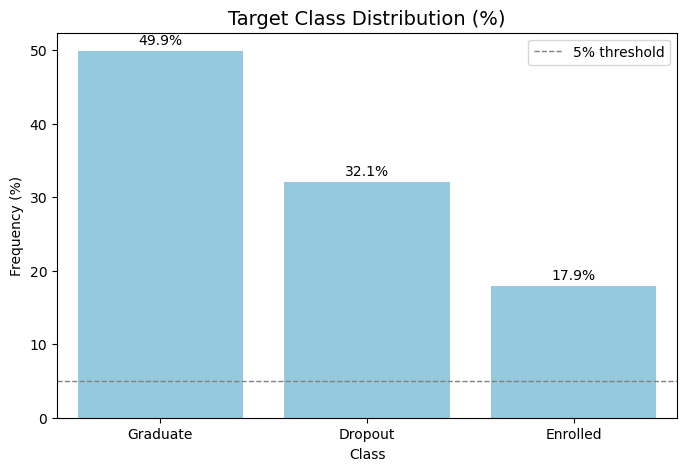

Class distribution in %:
Graduate: 49.9%
Dropout: 32.1%
Enrolled: 17.9%

Mode: Graduate


In [41]:
# Visualize class distribution with imbalance threshold
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

# Compute class frequencies in %
freq = (df["Target"].value_counts(normalize=True) * 100).round(1)
classes = freq.index
values = freq.values

# Identify minority classes (<5%)
colors = ["salmon" if val < 5 else "skyblue" for val in values]

# Bar plot
ax = sns.barplot(x=classes, y=values, palette=colors)

# Plot customization
ax.set_title("Target Class Distribution (%)", fontsize=14)
ax.set_xlabel("Class")
ax.set_ylabel("Frequency (%)")

# Add dashed 5% imbalance threshold
plt.axhline(5, color="gray", linestyle="--", linewidth=1, label="5% threshold")

# Annotate bar values
for i, val in enumerate(values):
    ax.text(i, val + 0.5, f"{val}%", ha="center", va="bottom", fontsize=10)

plt.legend()
plt.show()

# Print exact frequencies
print("Class distribution in %:")
for cls, val in freq.items():
    print(f"{cls}: {val}%")

# Mode
mode_value = df["Target"].mode()[0]
print(f"\nMode: {mode_value}")


### 3.2 - DUPLICATES

The dataset had been previously partially cleaned so there should not be any duplicates but let's check that. 

In [42]:
# Check for exact duplicates across all columns
exact_duplicates = df.duplicated().sum()
print(f"Exact duplicates found: {exact_duplicates}")

# View duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Total rows involved in duplication: {len(duplicate_rows)}")

# Remove exact duplicates (keep first occurrence)
df_cleaned = df.drop_duplicates(keep='first')

# Document the cleaning decision
cleaning_log = {
    'original_rows': len(df),
    'exact_duplicates_removed': len(df) - len(df_cleaned),
    'final_rows': len(df_cleaned)
}
print(f"Cleaning summary: {cleaning_log}")


Exact duplicates found: 0
Total rows involved in duplication: 0
Cleaning summary: {'original_rows': 4424, 'exact_duplicates_removed': 0, 'final_rows': 4424}


As you can see, there are no duplicates withing the dataset. Let's see if there are any missing values in the columns. 

### 3.3 - MISSING VALUES

In [43]:
# Check for missing values
missing_values = df_cleaned.isnull().sum()
print('Missing values in each column:')
print(missing_values)

Missing values in each column:
Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder               

In this dataset, it seems there are no missing values. If I had come across missing values in the data,
I would have considered using methods like fillna() or dropna(), based on my analytical needs and rationale, or I would have filled them with mean/median/mode after making appropriate choices (this would have been on the train set later on and would have been applied othe test set through a dedicated Pipeline so that cross-validation could have been properly performed at modeling stage).

Then, I also outputted the value counts for each categorical feature and this also helped me detect any potential formatting issue or inconsistencies.

### 3.4 - CATEGORICAL VALUE COUNTS

In [44]:
# CHECK VALUE COUNTS FOR CATEGORICAL FEATURES

# Candidate categorical features
categorical_candidates = [
    "Marital Status",
    "Application mode",
    "Application order",
    "Course",
    "Daytime/evening attendance",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International",
    "Target"
]

# Loop through and print value counts
for col in categorical_candidates:
    print(f"\n {col}")
    print(df_cleaned[col].value_counts(dropna=False))


 Marital Status
Marital Status
1    3919
2     379
4      91
5      25
6       6
3       4
Name: count, dtype: int64

 Application mode
Application mode
1     1708
17     872
39     785
43     312
44     213
7      139
18     124
42      77
51      59
16      38
53      35
15      30
5       16
10      10
2        3
57       1
26       1
27       1
Name: count, dtype: int64

 Application order
Application order
1    3026
2     547
3     309
4     249
5     154
6     137
9       1
0       1
Name: count, dtype: int64

 Course
Course
9500    766
9147    380
9238    355
9085    337
9773    331
9670    268
9991    268
9254    252
9070    226
171     215
8014    215
9003    210
9853    192
9119    170
9130    141
9556     86
33       12
Name: count, dtype: int64

 Daytime/evening attendance
Daytime/evening attendance
1    3941
0     483
Name: count, dtype: int64

 Nacionality
Nacionality
1      4314
41       38
26       14
6        13
22       13
24        5
100       3
11        3
103     

As you can see above, there is nothing that catches my attention and that I should take care of regarding this aspect.

### 3.5 - SENSITIVE ATTRIBUTE SCANNING

**Sensitive Attribute Scanner & Mitigation Playbook**

**Regulatory context**  
- *GDPR Article 9* (EU) → forbids processing “special category” personal data without explicit consent.  
- *ECOA* (U.S.) → prohibits discrimination in lending and decision-making.  
- In higher education, fairness is essential to avoid reinforcing inequality in access and outcomes.  

**Objective:**  
Identify potentially sensitive or proxy attributes in the student dataset (e.g., gender, nationality, socio-economic variables) and plan mitigation strategies.

In [45]:
# SENSITIVE ATTRIBUTE SCANNER WITH FUZZY MATCHING

sus_kw = ["gender", "sex", "race", "ethnicity", "religion", "pregnancy", "zipcode", "nationality"]
matches = utils.fuzzy_scan(df.columns, sus_kw, cutoff=0.6)
print("Potentially sensitive (fuzzy):", matches)


Potentially sensitive (fuzzy): {'gender': ['gender'], 'nationality': ['nacionality', 'international', 'inflation rate']}


**Mitigation Playbook**

**Detected sensitive attributes**  
- `Gender` (direct sensitive attribute)  
- `Nationality` (potential sensitive attribute)

I would also arbitrarily add:
- Socio-economic proxies (e.g., parental education and occupation, scolariship...)
and exclude:
- `Inflation rate`

**Mitigation strategies under consideration**  
- **Drop**: remove the attribute entirely if risk of bias outweighs predictive value (e.g., Gender).  
- **Blur**: coarsen categorical granularity (e.g., group nationalities into “domestic vs international”).  
- **Fairness constraints**: explore algorithmic approaches (e.g., Equal Opportunity, Demographic Parity) if fairness audits show imbalance.  
- **Post-hoc adjustment**: calibrate thresholds separately if model under-serves specific subgroups.

**Chosen initial strategy (PRD draft)**  
- Keep socio-economic proxies, as they reflect institutional realities and may guide interventions.  
- Drop or blur attributes like *Gender* and *Nationality* unless their inclusion is explicitly justified by fairness testing.  
- Commit to running subgroup fairness metrics in Milestone 6 before any deployment.


### 3.6 - LABEL

Then, I have made sure that my dataset meets the **MECE conditions**, namely if labels are mutually exclusive (ME - no row has more than one label) and collectively exhaustive (CE - no row is missing a label).

In [46]:
# MECE CHECK FOR THE TARGET LABEL
assert utils.mece_check(df, "Target"), "⚠️ Fix label scheme!"

✅ Labels are MECE.


### 3.7 - DATASET FEATURE SUMMARY

Below, I have set up a feature summary to store each column's information onto a dataframe so that I could refer back to it in the future in necessary.

In [47]:
# Build base summary
summary = pd.DataFrame({
    "Feature Name": df_cleaned.columns,
    "Type": df_cleaned.dtypes.astype(str),
    "Missing Values (%)": (df_cleaned.isnull().mean() * 100).round(2),
})

# Handle unique values differently for int vs float
unique_values = []
for col in df_cleaned.columns:
    if pd.api.types.is_integer_dtype(df_cleaned[col]):
        unique_values.append(df_cleaned[col].nunique())
    elif pd.api.types.is_float_dtype(df_cleaned[col]):
        unique_values.append("/")   # skip for continuous floats
    else:
        unique_values.append(df_cleaned[col].nunique())  # keep for object/categorical

summary["Unique Values"] = unique_values

# Convert DataFrame to Markdown
summary_md = summary.to_markdown(index=False)

# Save to reports folder
output_path = Path("../outputs/reports")
output_path.mkdir(parents=True, exist_ok=True)

with open(output_path / "feature_summary.md", "w", encoding="utf-8") as f:
    f.write("# Feature Summary\n\n")
    f.write(summary_md)


Below I have created a more in-depth summary table including notes on my understanding of the features and ethical considerations.I recommend checking out the **Assumptions / Ethical Considerations** column for each feature. 

**Side note**: I still have to perform a few cleaning operations on the features (starting from the names): all of this will be addressed in the next notebook.

# Feature Documentation

| Feature Name                                   | Type                              | # Datapoints | Keep (final-outcome) | Keep (early-warning by end of Sem1)* | Role    | Missing | Unique / Range (per UCI) | Notes                                                                 | Assumptions / Ethical Considerations                                                                 |
|-----------------------------------------------|-----------------------------------|--------------|----------------------|--------------------------------------|---------|---------|--------------------------|----------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| `Marital status`                              | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | {1…6}                    | Encoded status per UCI codes.                                        | Sensitive if used punitively; monitor fairness.                                                      |
| `Application mode`                            | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | many codes                | Encodes admission channel.                                           | May proxy socio-economic or regional access.                                                         |
| `Application order`                           | Numeric (int, discrete)           | 4424         | Keep                 | Keep                                 | Feature | 0       | 0–9                      | Lower is first choice.                                               | Backup-choice effect plausible.                                                                      |
| `Course`                                      | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | 17+ codes                 | Degree identifier.                                                   | Avoid stigmatizing programs; treat as context.                                                       |
| `Daytime/evening attendance`                  | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | Attendance regime.                                                   | Working students may cluster in evening.                                                             |
| `Previous qualification`                      | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | multiple edu levels       | Prior schooling level.                                               | Cross-system comparability caveat.                                                                   |
| `Previous qualification (grade)`              | Numeric (float, continuous)       | 4424         | Keep                 | Keep                                 | Feature | 0       | 0–200                    | Prior grade scale.                                                   | Different systems may map unevenly.                                                                  |
| `Nacionality`                                 | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | 20+ countries             | Encoded nationality.                                                 | Handle carefully to avoid bias amplification.                                                        |
| `Mother’s qualification`                      | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | many levels incl. unknown | Parental education.                                                  | SES proxy; use ethically.                                                                            |
| `Father’s qualification`                      | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | many levels incl. unknown | Parental education.                                                  | Same as above.                                                                                        |
| `Mother’s occupation`                         | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | encoded jobs              | Parental occupation.                                                 | SES proxy; treat carefully.                                                                          |
| `Father’s occupation`                         | Categorical (int, discrete)       | 4424         | Keep                 | Keep                                 | Feature | 0       | encoded jobs              | Parental occupation.                                                 | Same caution.                                                                                        |
| `Admission grade`                             | Numeric (float, continuous)       | 4424         | Keep                 | Keep                                 | Feature | 0       | 0–200                    | Entry score.                                                         | High predictor but may reflect inequality.                                                           |
| `Displaced`                                   | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | Lives away from family.                                              | May correlate with cost/strain.                                                                      |
| `Educational special needs`                   | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | Declared special needs.                                              | Treat with strict fairness monitoring.                                                               |
| `Debtor`                                      | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | Has unpaid dues.                                                     | Financial risk signal; avoid punitive use.                                                           |
| `Tuition fees up to date`                     | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | Fees status.                                                         | Strong predictor in literature; avoid making aid conditional on prediction.                          |
| `Gender`                                      | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | Encoded binary gender.                                               | Bias risk — audit model parity.                                                                      |
| `Scholarship holder`                          | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | Holds scholarship.                                                   | SES proxy; monitor interactions.                                                                     |
| `Age at enrollment`                           | Numeric (int, discrete)           | 4424         | Keep                 | Keep                                 | Feature | 0       | ~17–60                   | Age at start.                                                        | Non-linear effects likely.                                                                           |
| `International`                               | Categorical (int, binary)         | 4424         | Keep                 | Keep                                 | Feature | 0       | {0,1}                    | International student.                                               | Support needs may differ.                                                                            |
| `Curricular units 1st sem (credited)`         | Numeric (int, discrete)           | 4424         | Keep                 | Keep                                 | Feature | 0       | ≥0                       | Credits recognized in Sem1.                                          | Useful but may depend on prior experience recognition.                                               |
| `Curricular units 1st sem (enrolled)`         | Numeric (int, discrete)           | 4424         | Keep                 | Keep                                 | Feature | 0       | ≥0                       | Units enrolled Sem1.                                                 | High workload may predict dropout.                                                                   |
| `Curricular units 1st sem (evaluations)`      | Numeric (int, discrete)           | 4424         | Keep                 | Keep                                 | Feature | 0       | ≥0                       | Evaluations taken Sem1.                                              | Reflects engagement in first semester.                                                               |
| `Curricular units 1st sem (approved)`         | Numeric (int, discrete)           | 4424         | Keep                 | Keep                                 | Feature | 0       | ≥0                       | Units passed Sem1.                                                   | Strong performance indicator.                                                                        |
| `Curricular units 1st sem (grade)`            | Numeric (float, continuous)       | 4424         | Keep                 | Keep                                 | Feature | 0       | 0–20                     | Avg grade Sem1.                                                      | Key indicator; risk of leakage depends on prediction horizon.                                        |
| `Curricular units 1st sem (without evaluations)` | Numeric (int, discrete)        | 4424         | Keep                 | Keep                                 | Feature | 0       | ≥0                       | No-evaluation units Sem1.                                            | Reflects disengagement.                                                                              |
| `Curricular units 2nd sem (credited)`         | Numeric (int, discrete)           | 4424         | Keep                 | **Drop**                             | Feature | 0       | ≥0                       | Credits recognized Sem2.                                             | Leakage if predicting before/during Sem2.                                                            |
| `Curricular units 2nd sem (enrolled)`         | Numeric (int, discrete)           | 4424         | Keep                 | **Drop**                             | Feature | 0       | ≥0                       | Units enrolled Sem2.                                                 | Same note.                                                                                            |
| `Curricular units 2nd sem (evaluations)`      | Numeric (int, discrete)           | 4424         | Keep                 | **Drop**                             | Feature | 0       | ≥0                       | Evaluations taken Sem2.                                              | Same note.                                                                                            |
| `Curricular units 2nd sem (approved)`         | Numeric (int, discrete)           | 4424         | Keep                 | **Drop**                             | Feature | 0       | ≥0                       | Units passed Sem2.                                                   | Strong predictor but not valid for early-warning.                                                    |
| `Curricular units 2nd sem (grade)`            | Numeric (float, continuous)       | 4424         | Keep                 | **Drop**                             | Feature | 0       | 0–20                     | Avg grade Sem2.                                                      | Clear leakage for early-warning.                                                                     |
| `Curricular units 2nd sem (without evaluations)` | Numeric (int, discrete)        | 4424         | Keep                 | **Drop**                             | Feature | 0       | ≥0                       | No-evaluation units Sem2.                                            | Same note.                                                                                            |
| `Unemployment rate`                           | Numeric (float, continuous)       | 4424         | Keep                 | Keep                                 | Feature | 0       | 0–100 %                  | Macro context (percentage).                                          | Proxy for socio-economic context.                                                                    |
| `Inflation rate`                              | Numeric (float, continuous)       | 4424         | Keep                 | Keep                                 | Feature | 0       | -50–200 %                | Macro context (percentage).                                          | Can be negative (deflation) or very high (inflation spikes).                                         |
| `GDP`                                         | Numeric (float, continuous)       | 4424         | Keep                 | Keep                                 | Feature | 0       | -10–10 (growth index)    | GDP growth/variation index (not absolute GDP). Negative values = economic contractions. | Exogenous macro context; interpret as background pressure, not student-level ability.                 |
| `Target`                                      | Categorical (string)              | 4424         | —                    | —                                    | Target  | 0       | {Dropout, Enrolled, Graduate} | Outcome at normal duration end.                                     | Use to allocate support, not to penalize.                                                             |

\* **Early-warning** = prediction task defined at the end of the first semester. Any feature containing **performance within Sem2** counts as leakage for that purpose.


### 3.8 - IMPACT QUADRANT & QUANTITATIVE RISK TABLE

**Student Outcome Prediction** - Problem Spec, Stakeholder Mapping, and Risk Scores

This notebook documents:
- The **Five-Part Specification** (concise, machine-readable problem header)
- A **Stakeholder Mapping** using a 4-quadrant view (Direct/Indirect × Benefit/Harm)
- A **Quantitative Risk Table** with scores `R = Severity × Likelihood`
- A small **Leakage Guard** (phase-based) to prevent post-prediction evidence leakage

**Why this matters**
Early, well-framed predictions let universities provide timely support to students, improve retention, and reduce inequalities. Clear specs and risk maps make your project auditable, ethical, and deployment-ready.

In [48]:
# Five-Part Specification — project header
problem_spec = {
    "decision": "target_student_support",       # action taken following the prediction
    "unit": "student",                          # one record per student
    "event": "dropout_enrolled_graduate",       # multi-class target
    "horizon_semesters": "full_program",        # predict outcome by end of program
    "prediction_time": "end_of_semester_2",     # only evidence available by end of sem 2
    "feature_list": [
        # demographics (static at enrollment)
        "Age_at_enrollment","Gender","Marital_status","Nationality","Daytime_evening","International",
        # family background (static proxies of support)
        "Mother_qualification","Father_qualification","Mother_occupation","Father_occupation",
        # finance (early indicators)
        "Scholarship_holder","Tuition_fees_up_to_date","Debtor","Displaced",
        # entry academics
        "Previous_qualification","Previous_qualification_grade","Admission_grade","Application_mode","Application_order","Course",
        # semester 1 performance
        "CU1_credited","CU1_enrolled","CU1_evaluations","CU1_approved","CU1_grade","CU1_without_evaluations",
        # semester 2 performance
        "CU2_credited","CU2_enrolled","CU2_evaluations","CU2_approved","CU2_grade","CU2_without_evaluations",
        # macro context at enrollment
        "Unemployment_rate","Inflation_rate","GDP"
    ]
}
print("Five-Part Specification set → keys:", list(problem_spec.keys()))

Five-Part Specification set → keys: ['decision', 'unit', 'event', 'horizon_semesters', 'prediction_time', 'feature_list']


In [49]:
# Stakeholders and beneficiaries for the student outcome project
# We model risks explicitly as "risk items", not as people.
rows = [
    # entity, role, benefit_or_harm, proximity (0=indirect,1=direct), severity (1-5), likelihood (1-5), note
    ("Students",                "beneficiary", "benefit", 1, 5, 4, "Timely support, higher graduation likelihood."),
    ("Universities",            "beneficiary", "benefit", 1, 4, 4, "Retention gains, smarter resource allocation."),
    ("Educators/Advisors",      "stakeholder", "benefit", 1, 3, 3, "Decision-support for targeted interventions."),
    ("Families",                "beneficiary", "benefit", 0, 3, 3, "Lower stress and financial strain."),
    ("Labor Market",            "beneficiary", "benefit", 0, 3, 3, "More skilled graduates entering workforce."),
    ("Communities/Society",     "beneficiary", "benefit", 0, 3, 3, "Social mobility, reduced inequality."),

    # Explicit risk items (not people)
    ("Alert fatigue risk",      "risk_item",   "harm",   1, 3, 2, "Over-alerting if thresholds are naive."),
    ("Policy misuse risk",      "risk_item",   "harm",   0, 4, 2, "Overreliance on model outputs for funding or policy."),
]

stake = pd.DataFrame(rows, columns=[
    "entity","role","benefit_or_harm","proximity","severity","likelihood","note"
])
stake["risk_score"] = stake["severity"] * stake["likelihood"]

stake_sorted = stake.sort_values(["benefit_or_harm","risk_score"], ascending=[True, False]).reset_index(drop=True)
stake_sorted


,entity,role,benefit_or_harm,proximity,severity,likelihood,note,risk_score
0,Students,beneficiary,benefit,1,5,4,"Timely support, higher graduation likelihood.",20
1,Universities,beneficiary,benefit,1,4,4,"Retention gains, smarter resource allocation.",16
2,Educators/Advisors,stakeholder,benefit,1,3,3,Decision-support for targeted interventions.,9
3,Families,beneficiary,benefit,0,3,3,Lower stress and financial strain.,9
4,Labor Market,beneficiary,benefit,0,3,3,More skilled graduates entering workforce.,9
5,Communities/Society,beneficiary,benefit,0,3,3,"Social mobility, reduced inequality.",9
6,Policy misuse risk,risk_item,harm,0,4,2,Overreliance on model outputs for funding or p...,8
7,Alert fatigue risk,risk_item,harm,1,3,2,Over-alerting if thresholds are naive.,6


**Interpretation and Mitigations**
How to interpret

>- High R for “benefit” entities = biggest positive leverage points.
>- High R for “harm” risk items = priority risks that need mitigation.

So in this map:

>- Students (20) → primary beneficiaries → focus interventions here.
>- Universities (16) → secondary major beneficiaries.
>- Alert fatigue risk (6) and Policy misuse risk (8) → modest risks, but worth monitoring.

**Who benefits most (large bubbles, direct/benefit):**
- Students → largest positive impact (R often ≥ 15 depending on scoring).
- Universities → strong positive impact via retention and resource focus.
- Educators/Advisors → decision-support for targeted actions, not replacement.

**Potential harms (explicit risk items):**
- **Alert fatigue risk (Direct/Harm)**  
  - *Mitigate:* threshold tuning, batched triage, weekly caps, clear action playbooks.
- **Policy misuse risk (Indirect/Harm)**  
  - *Mitigate:* governance guardrails, human-in-the-loop review, audit logs, fairness monitoring, transparent documentation of limits.

**Why educators and policymakers are not labeled as harm**
- They are **stakeholders** who act on model insights.  
- Harm can arise from **implementation choices** (too many alerts, overreliance in high-stakes policy), not from the people themselves.  
- We therefore keep them as stakeholders/beneficiaries and model harms as **separate risk items**.

### 3.9 - FRAMING & COMPLIANCE CHECKLIST

>- Positive class size → Yes. The “Dropout” class contains more than 50 examples in the UCI dataset, satisfying minimum sample requirements.

>- MECE labels → Yes. Labels are mutually exclusive (Dropout, Enrolled, Graduate) and collectively exhaustive.

>- Sensitive attributes → Identified and mitigation planned. Gender and nationality flagged; strategies include fairness audits and optional removal.

>- Temporal leakage test → Passes. Only Semester 1 features are used at prediction time; Semester 2+ features are excluded (this is definied in 02_data_cleaning.ipynb)

>- Stakeholder map → Includes harms. Both “alert fatigue” and “policy misuse” are explicitly documented as potential risks.

>- Data audit composite score → ≥ 15. Accuracy, completeness, consistency, relevance, and veracity assessed as moderate to good.

>- Baseline vs random → Expected to pass. Logistic Regression baseline expected to outperform random guessing (>20% above majority class baseline).

>- Compliance checklist → Complete. /docs/compliance.md details risk tier, GDPR handling, oversight, and fairness monitoring.

>- Error-cost matrix → Attached. False negatives (missed at-risk students) cost more than false positives (extra interventions).

>- Version control & peer review → In place. PRD maintained in Git, with peer review scheduled as part of milestone submission.

In [53]:
# Save dataset
utils.save_dataset(df, 'interim/01_students_dropout_data_forCleaning.xlsx')

File saved at: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Classification\Early_Identification_Of_At-Risk_Students\data\interim\01_students_dropout_data_forCleaning.xlsx


<div class="alert alert-block alert-info">
<b>Next Notebook - Data Cleaning
</div>